# SIM-SOENS
This is a walkthrough of basic SIM-SOENs functionality, along with supporting input, readout, and analitic tools--all in a common syntax defined specifically for working with Simulated Superconducting Optoelectronic Networks (Sim-SOENs).

- Start with importing necesary libraries, modules, and Sim-SOEN-sepcific assets.

In [1]:
import numpy as np

from _util import physical_constants, set_plot_params, index_finder
from _util__soen import dend_load_rate_array, dend_load_arrays_thresholds_saturations
from soen_sim import input_signal, synapse, neuron, network
from soen_sim_lib__common_components__simple_gates import common_dendrite, common_synapse, common_neuron

from _plotting__soen import raster_plot
from super_net import SuperNet
from super_input import SuperInput
from zoo import CustomNeurons
from params import default_neuron_params




Complete!


## Input
Before delving into neuron and network dynamics, let's first get familiar with input defitions.
- Significant felxibility is available for generating spiking input that is natively understood by Sim-SOENs.
- A few key parameters should be passed into the `Input` class.
- A number of hidden parameters may also be definted and are otherwise set to default values.
- The code below generates a single input channel of random spiking events for a duration of 100ns.

Generating random input...


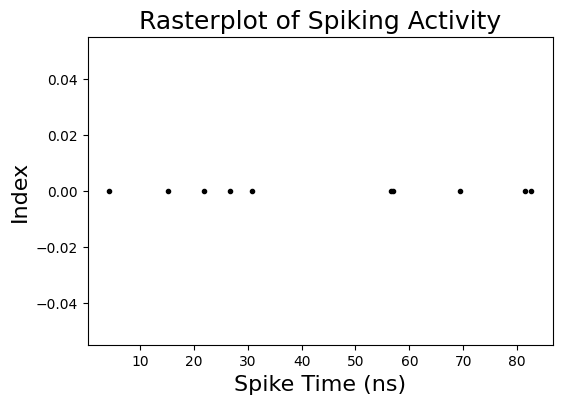

In [2]:
input_single = SuperInput(channels=1, type='random', total_spikes=10, duration=100)
raster_plot(input_single.spike_arrays,notebook=True)

Generating random input...


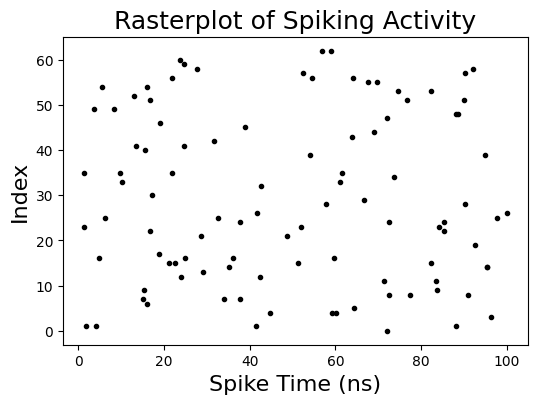

In [3]:
# More channels, more spikes
input_multi = SuperInput(channels=64, type='random', total_spikes=100, duration=100)
raster_plot(input_multi.spike_arrays,notebook=True)

### Spiking MNIST Dataset
The classic MNIST handwritten digit dataset can be generated by assigning each of the 28x28 pixels an input channel index, and generating Poisson spiking-even distributions with rates according to the pixel intensity at that pixel
- Note that the `slow_down` argument corresponds to the factor by which rates are slowed down (SOENs like data to have a frequency less that 1 spike per 35 ns)
- *Fix indexing and add all digits

Generating MNNIST dataset...
load
loaded


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


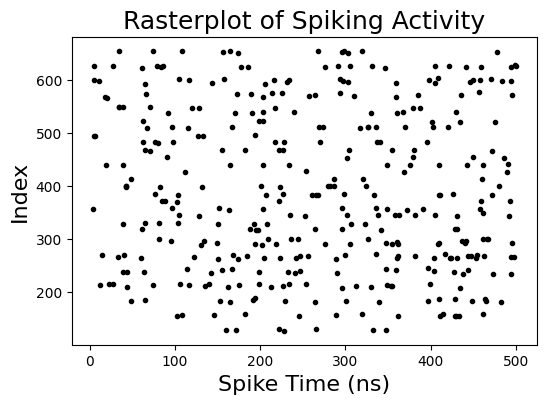

In [4]:
# *change to load previously generated patterns
input_MNIST = SuperInput(type='MNIST', index=0, slow_down=10, duration=500)
raster_plot(input_MNIST.spike_arrays,notebook=True)

## The Neuron
SOEN neurons have special structure that corresponds to their physical design parameters.
- At least one SPD synaspse
- At least one SQUID-dendrite
- One SQUID soma
- One refractory SQUID-dendrite
- *A SQUID a superconducting quantum interference device, but computationally can be though of as a simple signal integrator with a leak

To call a simple single-synapse, single-dendrite neuron, use:

Generating pre-defined input...

running network time stepper for 5.00e+02ns (501 time steps) ...
done running network time stepper. t_sim = 1.99990e-02s



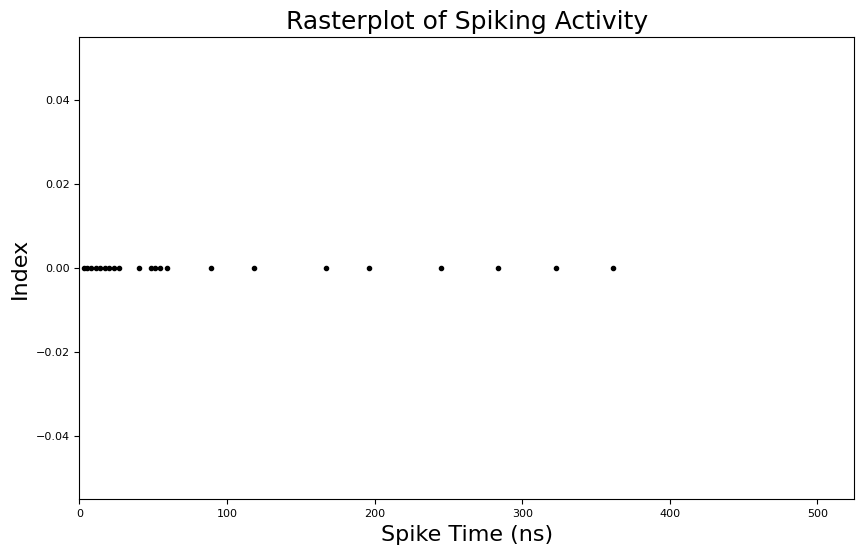

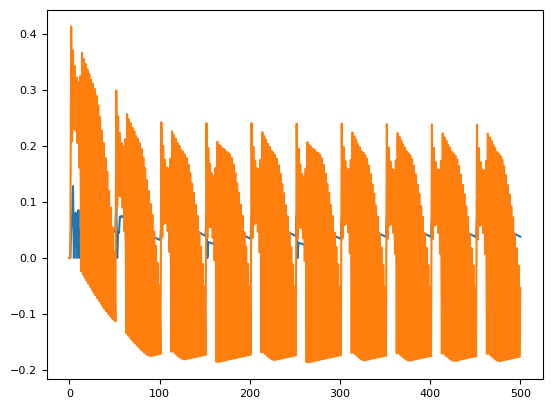

In [30]:
times = np.arange(0,500,50)
indices = np.zeros(len(times)).astype(int)
def_spikes = [indices,times]

# input_ = SuperInput(channels=1, type='random', total_spikes=int(500/42), duration=500)
input_ = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=500)

default_neuron_params['w_dn'] = 0.75
default_neuron_params['tau_di'] = 1
sing = CustomNeurons(type='single',**default_neuron_params)
sing.synapse.add_input(input_.signals[0])

net = network(name = 'network_under_test')
net.add_neuron(sing.neuron)
net.run_sim(dt = 1, tf = 500)
net.get_recordings()
# for neuron_key in net.neurons:
#     items = net.neurons[neuron_key]
#     print(items.__dict__)

# sing.plot_simple = True
# net.plot()

# raster_plot(input_.spike_arrays,duration=500)
raster_plot(net.spikes,duration=500,input=input_.spike_arrays)
import matplotlib.pyplot as plt
plt.plot(net.signal[0])
plt.plot(net.phi_r[0])

## Dendritic Arbor
- A single synapse (currently) can only take input from one upstream source
- Therefore, to accomodate more sizeable fan-in, dendritc arbors may be constructed

In [12]:
# code
neo = CustomNeurons(type='3fractal',**default_neuron_params)

layer: 0
  dendrite 0
  dendrite 1
  dendrite 2
layer: 1
  dendrite 0
  dendrite 1
  dendrite 2
  dendrite 3
  dendrite 4
  dendrite 5
  dendrite 6
  dendrite 7
  dendrite 8


Generating random input...


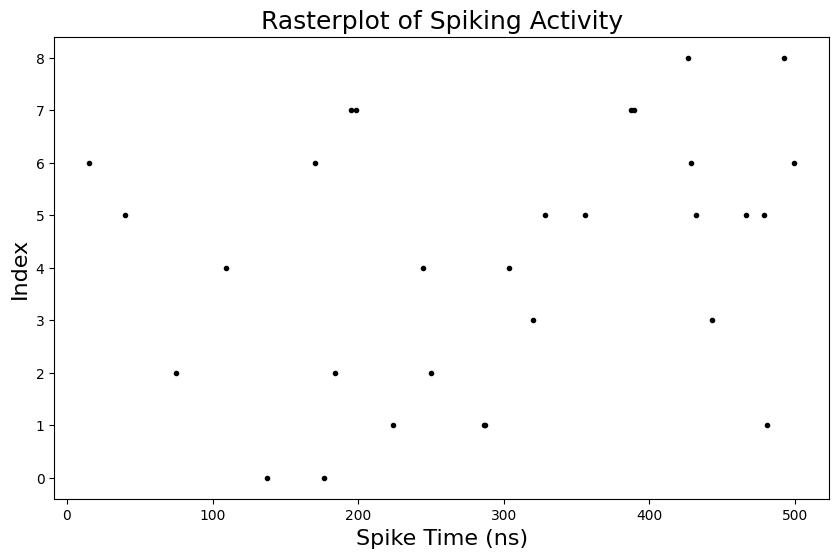


running network time stepper for 1.00e+03ns (101 time steps) ...
done running network time stepper. t_sim = 2.10012e-02s



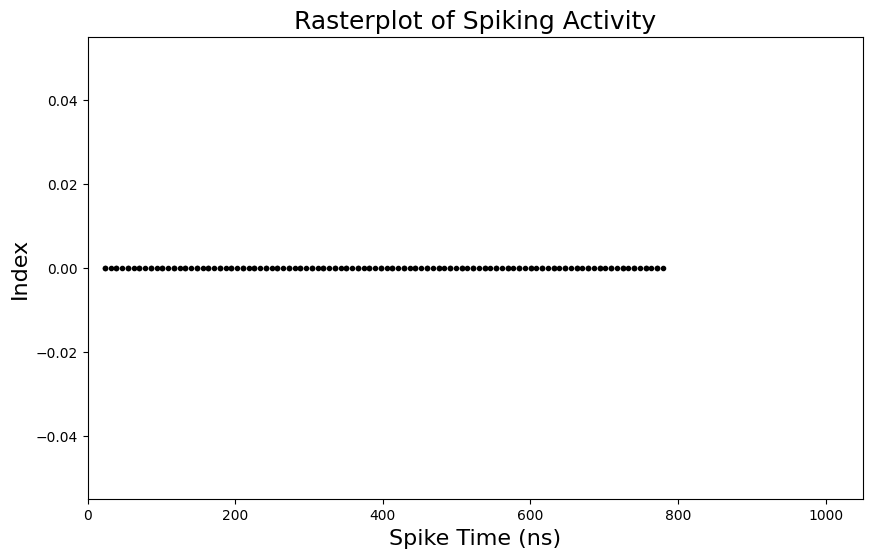

In [17]:
input = SuperInput(channels=9, type='random', total_spikes=30, duration=500)
raster_plot(input.spike_arrays)
for i in range(len(neo.synapses)):
    in_ = input_signal(name = 'input_synaptic_drive', 
                       input_temporal_form = 'arbitrary_spike_train', 
                       spike_times = input.spike_rows[i])
    neo.synapses[i].add_input(in_)

net = network(name = 'network_under_test')
net.add_neuron(neo.fractal_neuron)
# net.neurons['name'].name = 1

# network_object.neurons[neuron_key].dend__ref.synaptic_inputs['{}__syn_refraction'.format(network_object.neurons[neuron_key].name)].spike_times_converted = np.append(network_object.neurons[neuron_key].dend__ref.synaptic_inputs['{}__syn_refraction'.format(network_object.neurons[neuron_key].name)].spike_times_converted,tau_vec[ii+1])
net.run_sim(dt = 10, tf = 1000)
spikes = [ [] for _ in range(2) ]
S = []
Phi_r = []
count = 0
for neuron_key in net.neurons:
    s = net.neurons[neuron_key].dend__nr_ni.s
    S.append(s)
    phi_r = net.neurons[neuron_key].dend__nr_ni.phi_r
    Phi_r.append(phi_r)
    spike_t = net.neurons[neuron_key].spike_times
    spikes[0].append(np.ones(len(spike_t))*count)
    spikes[1].append(spike_t)
    count+=1
spikes[0] =np.concatenate(spikes[0])
spikes[1] = np.concatenate(spikes[1])/1000

raster_plot(spikes,duration=1000)

## Networking

In [27]:
input_MNIST = SuperInput(type='MNIST', index=0, slow_down=100, duration=500)

Generating MNNIST dataset...
load
loaded


input neurons:  27

running network time stepper for 5.02e+02ns (503 time steps) ...
done running network time stepper. t_sim = 8.89405e+00s

spikes


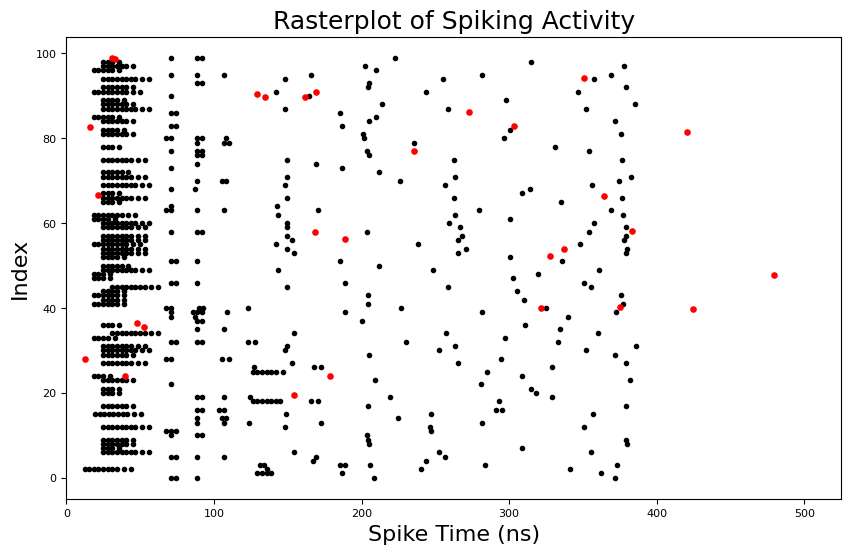

In [29]:

single_neuron = SuperNet(N=100,duration=500,in_connect="ordered") #dendrites,synapses
single_neuron.connect_input(input_MNIST)
single_neuron.run()
single_neuron.record(['spikes'])
spikes = single_neuron.spikes
raster_plot(spikes,duration=500,input=input_MNIST.spike_arrays)